# Regresja liniowa

[Piotr Migdał](http://migdal.wikidot.com/) i Łukasz Jonak, 2015, [DELab UW](http://www.delab.uw.edu.pl/)

In [32]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [33]:
df = pd.read_csv("../dane/SkillCraft1_Dataset.csv", na_values=["?"])

In [34]:
# przetwarzamy zgodnie z poprzednim plikiem (dzien4_czesc2_eksploracja_i_wykresy.ipynb)
df = df[df.LeagueIndex < 8]
df = df.loc[:,"LeagueIndex":"APM"]
df[df.TotalHours < 100000]
df_przeskalowane = df.query("HoursPerWeek > 0")[["LeagueIndex"]].copy()
for col in df.columns[1:]:
    df_przeskalowane[col + "_log10"] = np.log10(df[col])
df_przeskalowane = df_przeskalowane.dropna()

Jest kilka bibiliotek wspierających [regresję liniową](https://en.wikipedia.org/wiki/Linear_regression). Zacznijmy od prostszego podejścia korzystającego z pakietu [StatsModels](http://statsmodels.sourceforge.net/) zawierającego popularne metody statystyczne.

In [35]:
import statsmodels.formula.api as smf

In [36]:
# formuła z wyliczeniem zmiennych
formula = 'LeagueIndex ~ Age_log10 + HoursPerWeek_log10 + TotalHours_log10 + APM_log10'
result = smf.ols(formula, data=df_przeskalowane).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            LeagueIndex   R-squared:                       0.504
Model:                            OLS   Adj. R-squared:                  0.504
Method:                 Least Squares   F-statistic:                     847.0
Date:                Thu, 16 Jul 2015   Prob (F-statistic):               0.00
Time:                        20:54:35   Log-Likelihood:                -4799.4
No. Observations:                3337   AIC:                             9609.
Df Residuals:                    3332   BIC:                             9639.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
Intercept             -7.6618      0.404    -18.983      0.000        -8.453    -6.870
Age_log10              0.2743      0.233      1.177      0.239        -0.183     0.731
HoursPerWeek_log10    -0.1755      0.063     -2.766      0.006        -0.300    -0.051
TotalHours_log10       1.0009      0.052     19.320      0.000         0.899     1.102
APM_log10              4.4257      0.108     40.810      0.000         4.213     4.638
==============================================================================
Omnibus:                       40.614   Durbin-Watson:                   2.036
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               41.815
Skew:                          -0.270   Prob(JB):                     8.32e-10
Kurtosis:                       2.900   Cond. No.                         101.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [37]:
# Gdy wzór jest długi i nie chczemy go przepisywać, możemy prawą stronę zapisać następująco:
" + ".join(df_z.columns[1:])

'Age_log10 + HoursPerWeek_log10 + TotalHours_log10 + APM_log10'

Jeśli zaś zależy nam na ważność parametrów, możemy dane przeskalować.

In [38]:
df_z = (df_przeskalowane - df_przeskalowane.mean())/df_przeskalowane.std()

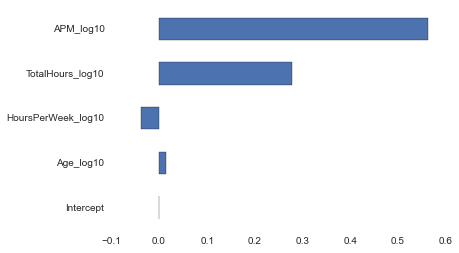

In [39]:
result = smf.ols(formula, data=df_z).fit()
result.params.plot(kind='barh')

Jeśli zaś czujemy się na siłach, możemy skorzystać z ogólniejszego pakiety - [scikit-learn](http://scikit-learn.org/). O ile w przypadku regresji liniowej to jest trudniejsze podejście, to w ten sam sposób można korzystać z wielu różnych metod statystycznych i uczenia maszynowego.

In [40]:
from sklearn import linear_model

In [41]:
# zamieniamy 'wejscie' ma array X, a 'wyjscie' na array Y 
Y = df_z["LeagueIndex"].values
X = df_z.drop("LeagueIndex", axis=1).values

In [42]:
Y

array([ 0.60760987,  0.60760987, -0.08298759, ..., -0.08298759,
       -0.77358505, -0.08298759])

In [43]:
Y.shape

(3337,)

In [44]:
X

array([[ 1.30107297, -0.30753131,  2.02225073,  0.73886103],
       [ 0.42471823, -0.30753131,  2.57261862,  0.48849084],
       [ 1.87692217, -0.30753131, -0.89542568, -0.95768198],
       ..., 
       [-0.07248915, -0.61805155, -1.64222837,  0.34695749],
       [-0.3391524 ,  1.12525784, -0.14862299,  0.57887136],
       [ 0.18176657, -1.01838176, -0.14862299, -0.39510847]])

In [45]:
X.shape

(3337, 4)

In [46]:
reg = linear_model.LinearRegression()  # tworzymy pusty model
reg.fit(X, Y)  # dopasowujemy model do danych (obiekt 'reg' przechowuje parametry)

LinearRegression(copy_X=True, fit_intercept=True, normalize=False)

In [47]:
# współczynnik regresji
reg.coef_

array([ 0.01505044, -0.0378322 ,  0.2786152 ,  0.56325188])

In [48]:
wspolczynniki = pd.Series(reg.coef_, index=df_z.columns[1:])
wspolczynniki

Age_log10             0.015050
HoursPerWeek_log10   -0.037832
TotalHours_log10      0.278615
APM_log10             0.563252
dtype: float64

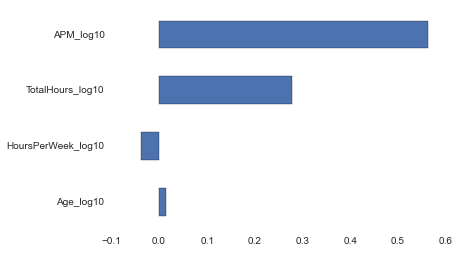

In [49]:
wspolczynniki.plot(kind='barh')

In [55]:
# mozna tez przewidywać
reg.predict([[1,0,0,0]])

array([ 0.01505044])

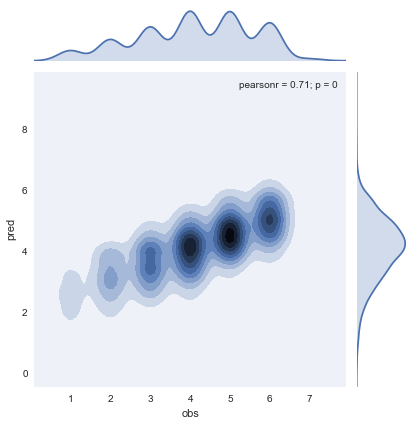

In [57]:
# a jak zobaczyc na ile dobrze potrafimy przewidziec wyniki?

# tworzymy dataframe z prawdziwymi obserwacjami i predykcją
predykcja = pd.DataFrame({'obs': Y, 'pred': reg.predict(X)})

# skalujemy wyniki
predykcja = (predykcja * df_przeskalowane['LeagueIndex'].std()) + df_przeskalowane['LeagueIndex'].mean()

sns.jointplot(x="obs", y="pred", data=predykcja, kind='kde')

## Zobacz też

* [Statistical functions (scipy.stats)¶](http://docs.scipy.org/doc/scipy/reference/stats.html)
* [Probabilistic Programming and Bayesian Methods for Hackers](http://nbviewer.ipython.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter1_Introduction/Chapter1.ipynb)